<a href="https://colab.research.google.com/github/Polinia/projects_Portfolio/blob/main/module_7/pr_car_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> This is an example of solving a problem using Keras.
# Image classification

### The main idea of this solution is to take the Xception network pre-trained on ImageNet and train it for our task.


In [ ]:
!nvidia-smi -q
!pip install -U albumentations -q
!pip install -U git+https://github.com/albumentations-team/albumentations -q
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [ ]:
# Uploading efficientnet model
!pip install -q efficientnet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
import tensorflow.keras as keras
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *


from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm


import PIL
from PIL import ImageOps, ImageFilter
#increase the default chart size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Tensorflow   : 2.6.4
Keras        : 2.6.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# basic settings

In [ ]:
# In setup we take out the main settings. It’s more comfortable to sort them out in the future.

EPOCHS               = 8  # epochs for training
BATCH_SIZE           = 32 # reduce the batch if the network is large, otherwise it will not fit into the memory on the GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # quantity of data we allocate for the test= 20%

CLASS_NUM            = 10  # number of classes
IMG_SIZE             = 224 # the size of images we send to the network
IMG_CHANNELS         = 3   # RGB has 3 channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # working directory


In [ ]:
# Set a specific random seed value for reproducibility
# os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [ ]:
#function that displays the chart
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# EDA / Data analysis

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()
# the distribution of classes is fairly even - that's good

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Unpacking pictures')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip, "r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Unpacking pictures
['train', 'test_upload']


Pictures examples (random sample)


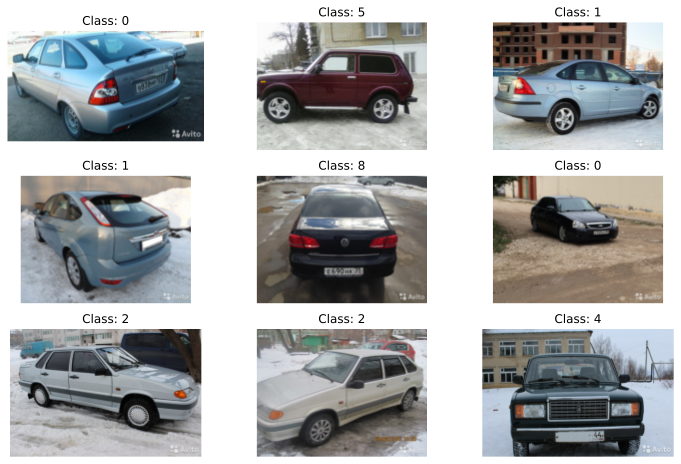

In [ ]:
print('Pictures examples (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

**We can guess that the classes mean the car model.**

Pictures examples (random sample)


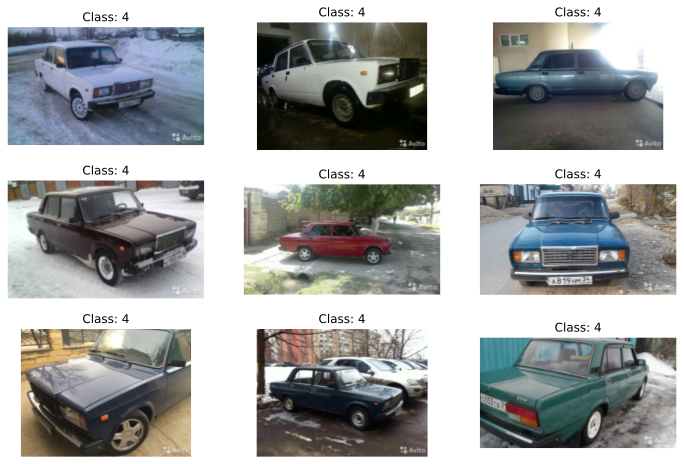

In [ ]:
# make sure class labels are loaded correctly
print('Pictures examples (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df[train_df['Category'] == 4].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

And you can see from the examples that the images have different sizes.

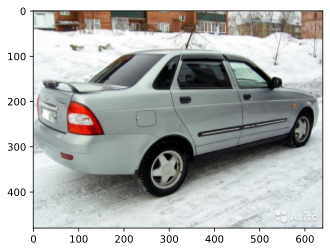

(640, 480)

In [ ]:
#Let's look at examples of images and their sizes in order to understand how best to process and compress them.
image = PIL.Image.open(PATH+'/train/0/189956.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Most photos of cars are 640x480, but there are also smaller photos.

In total, we have 22236 photos of cars (6675 in the test and 15561 in the train)

# Data preprocessing

### Data augmentation:
Let's perform data augmentation. In our case, it is important, since we are working with a small dataset.

### first checked the baseline option:

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1/ 255,
#     rotation_range = 50,
#     shear_range=0.2,
#     brightness_range=[0.5, 1.5],
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False,
#     fill_mode='nearest')

# test_datagen = ImageDataGenerator(rescale=1/ 255)

Let's try to work with a more advanced image augmentation library called albumentations. The big advantage of this library is that it is FAST and highly customizable.

In [ ]:
AUGMENTATIONS = albumentations.Compose([
        albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.01,
                       interpolation=1, border_mode=4, rotate_limit=20, p=.75),
        albumentations.RandomCrop(width=200, height=224),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Flip(p=0.5),
        albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.5, contrast_limit=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
        ], p=0.5),
        albumentations.HueSaturationValue(p=0.5),
        albumentations.RGBShift(p=0.5),
        albumentations.Resize(IMG_SIZE, IMG_SIZE),
    ])

### Data generation

In [ ]:
# dataloaders. I will make a function for convenient use in the future when changing BATCH_SIZE
def building_generators():
    train_datagen = ImageDataAugmentor(
                    rescale=1/255,             # since I take from the efficientnet pip package, normalization is needed
                    augment=AUGMENTATIONS,
                    validation_split=VAL_SPLIT)

    train_generator = train_datagen.flow_from_directory(
                    PATH+'train/',
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical',
                    shuffle=True, seed=RANDOM_SEED,
                    subset='training')


    test_datagen = ImageDataAugmentor(rescale=1/255, validation_split=VAL_SPLIT)

    test_generator = test_datagen.flow_from_directory(
                    PATH+'train/',
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical',
                    shuffle=True, seed=RANDOM_SEED,
                    subset='validation')  # set as validation data

    test_sub_generator = test_datagen.flow_from_dataframe( 
                    dataframe=sample_submission,
                    directory=PATH+'test_upload/',
                    x_col="Id",
                    y_col=None,
                    shuffle=False,
                    class_mode=None,
                    seed=RANDOM_SEED,
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=BATCH_SIZE,)
    return(train_generator,test_generator,test_sub_generator)

In [ ]:
(train_generator,test_generator,test_sub_generator) = building_generators()

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:456: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


For validation, we use a different source test_datagen.flow_from_dataframe without augmentation, since real images are needed to evaluate the model, not transformed ones.

Pictures examples from train_generator


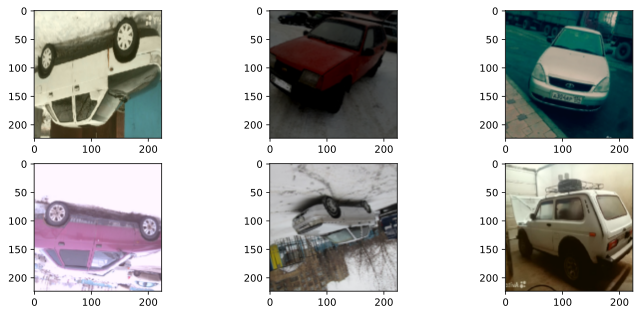

In [ ]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Pictures examples from train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    image = image.astype(np.uint8)

plt.show()

Pictures examples from test_generator


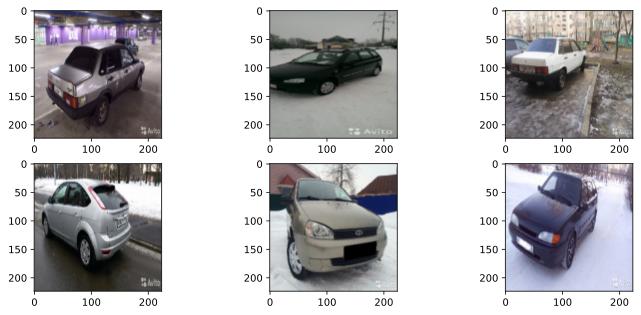

In [ ]:
x,y = test_generator.next()
print('Pictures examples from test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    image = image.astype(np.uint8)
plt.show()

# Building and training the complete model

In [ ]:
base_model = efn.EfficientNetB7(
    weights='imagenet', include_top=False, input_shape=input_shape)

2022-12-09 02:01:55.138823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 02:01:55.238260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 02:01:55.239157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 02:01:55.240648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258449408/258434480 [==============================] - 15s 0us/step


In [ ]:
model = M.Sequential()
model.add(base_model) #added a new network to the overall structure
model.add(L.GlobalAveragePooling2D(),)
#expiremented with:
# model.add(L.Dense(256, activation='relu')) 
# model.add(L.BatchNormalization()) 

model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
IMG_SIZE = 512
BATCH_SIZE = 6 #lowered because there was a constant error with memory
(train_generator,test_generator,test_sub_generator) = building_generators()

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
checkpoint = ModelCheckpoint('best_model_full7.hdf5' , monitor = 'val_accuracy',
                             verbose = 1  , mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor='accuracy', patience=5, 
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/8
2075/2075 [==============================] - 821s 381ms/step - loss: 1.8026 - accuracy: 0.3687 - val_loss: 1.2786 - val_accuracy: 0.5747

Epoch 00001: val_accuracy improved from -inf to 0.57474, saving model to best_model_full7.hdf5
Epoch 2/8
2075/2075 [==============================] - 785s 378ms/step - loss: 1.5758 - accuracy: 0.4441 - val_loss: 0.9398 - val_accuracy: 0.6997

Epoch 00002: val_accuracy improved from 0.57474 to 0.69974, saving model to best_model_full7.hdf5
Epoch 3/8
2075/2075 [==============================] - 783s 377ms/step - loss: 1.4514 - accuracy: 0.4928 - val_loss: 1.1150 - val_accuracy: 0.6743

Epoch 00003: val_accuracy did not improve from 0.69974
Epoch 4/8
2075/2075 [==============================] - 781s 377ms/step - loss: 1.3475 - accuracy: 0.5157 - val_loss: 1.4239 - val_accuracy: 0.6501

Epoch 00004: val_accuracy did not improve from 0.69974
Epoch 5/8
2075/2075 [==============================] - 783s 377ms/step - loss: 1.2668 - accuracy: 0.5517 

In [ ]:
model.save('../working/model_full.hdf5')
model.load_weights('best_model_full7.hdf5')

scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Fine-tuning

### Step 1
### Loading the pretrained network:

In [ ]:
input_shape

(224, 224, 3)

In [ ]:
#I will try one of the latest and best performing models
base_model = efn.EfficientNetB7(
    weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
# Firstable, the network that was loaded is not trained in any way.
# We will train only the upper layers that we randomly initialized
base_model.trainable = False

In [ ]:
# Install a new "head" 
model = M.Sequential()
model.add(base_model) #added a new network to the overall structure
model.add(L.GlobalAveragePooling2D(),) # combine all features into a single vector
model.add(L.Dense(256, activation='relu')) 
# model.add(L.BatchNormalization()) # the experiment showed that BatchNormalization worsens accuracy a little
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
# check the number and status of layers
print(len(model.layers))

for layer in model.layers:
    print(layer, layer.trainable)

5
<keras.engine.functional.Functional object at 0x7f67f2f19e10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f67f2e58950> True
<keras.layers.core.Dense object at 0x7f68361b4b50> True
<keras.layers.core.Dropout object at 0x7f6895f76f90> True
<keras.layers.core.Dense object at 0x7f67f2db83d0> True


### Model fitting

At the moment, the best optimizer is ADAM, so I will use it. It learns faster and more efficiently.

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',
                             verbose=1, mode='max', save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# Fitting
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

2022-12-09 21:25:51.451106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2022-12-09 21:26:09.692092: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


875/875 [==============================] - 560s 612ms/step - loss: 2.0662 - accuracy: 0.2464 - val_loss: 1.6903 - val_accuracy: 0.4124

Epoch 00001: val_accuracy improved from -inf to 0.41237, saving model to best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
875/875 [==============================] - 530s 605ms/step - loss: 1.8365 - accuracy: 0.3434 - val_loss: 1.4948 - val_accuracy: 0.4826

Epoch 00002: val_accuracy improved from 0.41237 to 0.48260, saving model to best_model.hdf5
Epoch 3/8
875/875 [==============================] - 531s 606ms/step - loss: 1.7610 - accuracy: 0.3650 - val_loss: 1.3933 - val_accuracy: 0.5303

Epoch 00003: val_accuracy improved from 0.48260 to 0.53028, saving model to best_model.hdf5
Epoch 4/8
875/875 [==============================] - 530s 605ms/step - loss: 1.7074 - accuracy: 0.3842 - val_loss: 1.3135 - val_accuracy: 0.5747

Epoch 00004: val_accuracy improved from 0.53028 to 0.57474, saving model to best_model.hdf5
Epoch 5/8
875/875 [==============================] - 528s 603ms/step - loss: 1.6463 - accuracy: 0.4088 - val_loss: 1.2510 - val_accuracy: 0.5915

Epoch 00005: val_accuracy improved from 0.57474 to 0.59149, saving model to best_model.hdf5
Epoch 6/8
875/875 [=============================

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

97/97 [==============================] - 57s 536ms/step - loss: 1.1630 - accuracy: 0.6050
Accuracy: 60.50%


In [ ]:
model.save('../working/model_step1.hdf5')
# model.load_weights('best_model.hdf5')

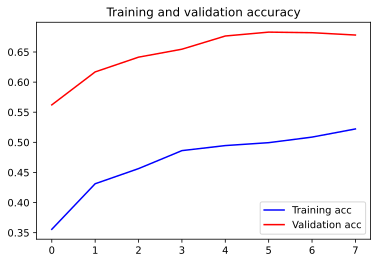

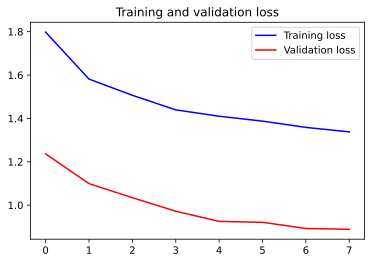

In [ ]:
plot_history(history)

## Fine Tuning: step 2

In [ ]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


## Freeze half of the layers

In [ ]:
base_model.trainable = True

# We will work with layers from now on
fine_tune_at = len(base_model.layers)//2

# Freeze all other layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# check the status of the layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f7b57945c50> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f7fa02b2f90> True
<keras.layers.core.Dense object at 0x7f7fea3d2710> True
<keras.layers.core.Dropout object at 0x7f7fa0260990> True
<keras.layers.core.Dense object at 0x7f7fa02b4650> True


In [ ]:
# check by number of layers
len(base_model.trainable_variables)

354

## Обучение модели

In [ ]:
BATCH_SIZE = 8  # reduce for having enough memory later

(train_generator,test_generator,test_sub_generator) = building_generators()

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               655616    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 64,755,866
Trainable params: 59,741,218
Non-trainable params: 5,014,648
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=
                             'val_accuracy', verbose=1, mode='max', save_best_only=True)
earlystop = EarlyStopping(
    monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# Fitting
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples//test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/8
1751/1751 [==============================] - 1073s 590ms/step - loss: 1.4228 - accuracy: 0.4839 - val_loss: 0.4443 - val_accuracy: 0.8189

Epoch 00001: val_accuracy improved from -inf to 0.81894, saving model to best_model.hdf5
Epoch 2/8
1751/1751 [==============================] - 1029s 588ms/step - loss: 1.0208 - accuracy: 0.6308 - val_loss: 0.2954 - val_accuracy: 0.8860

Epoch 00002: val_accuracy improved from 0.81894 to 0.88595, saving model to best_model.hdf5
Epoch 3/8
1751/1751 [==============================] - 1028s 587ms/step - loss: 0.8832 - accuracy: 0.6832 - val_loss: 0.2341 - val_accuracy: 0.9175

Epoch 00003: val_accuracy improved from 0.88595 to 0.91753, saving model to best_model.hdf5
Epoch 4/8
1751/1751 [==============================] - 1028s 587ms/step - loss: 0.8077 - accuracy: 0.7069 - val_loss: 0.3237 - val_accuracy: 0.8853

Epoch 00004: val_accuracy did not improve from 0.91753
Epoch 5/8
1751/1751 [==============================] - 1028s 587ms/step - lo

In [ ]:
# save the final network and load the best training iteration (best_model)
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')


In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

194/194 [==============================] - 55s 281ms/step - loss: 0.2341 - accuracy: 0.9175
Accuracy: 91.75%


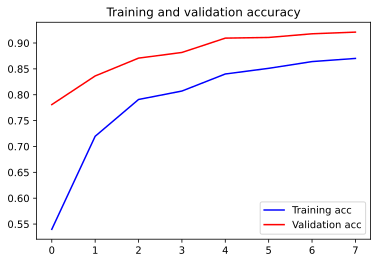

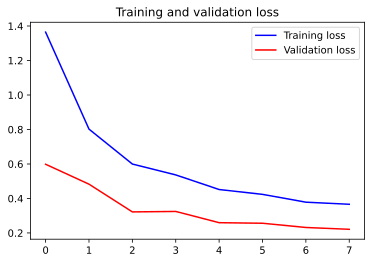

In [ ]:
plot_history(history)

## Step 3

Unfreeze all other layers

In [ ]:
base_model.trainable = True 

len(base_model.trainable_variables)

709

In [ ]:
#reduce batch size if it doesn't fit into memory
BATCH_SIZE = 4
LR = 0.0001 #reducing a bit of LR
(train_generator,test_generator,test_sub_generator) = building_generators()

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.
Found 6675 validated image filenames.


Let's try to use ExponentialDecay to control the learning rate

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(
    learning_rate=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,755,866
Trainable params: 64,445,146
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
# add a callback to save the model with the best performance
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=
                             'val_accuracy', verbose=1, mode='max',save_best_only=True)
earlystop = EarlyStopping(
    monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

2022-12-10 02:53:05.694213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2022-12-10 02:53:38.192305: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3503/3503 [==============================] - 1079s 297ms/step - loss: 1.7435 - accuracy: 0.3763 - val_loss: 0.3314 - val_accuracy: 0.8537

Epoch 00001: val_accuracy improved from -inf to 0.85374, saving model to best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
3503/3503 [==============================] - 1048s 299ms/step - loss: 1.2737 - accuracy: 0.5485 - val_loss: 0.2387 - val_accuracy: 0.8943

Epoch 00002: val_accuracy improved from 0.85374 to 0.89433, saving model to best_model.hdf5
Epoch 3/8
3503/3503 [==============================] - 1040s 297ms/step - loss: 1.0972 - accuracy: 0.6120 - val_loss: 0.1945 - val_accuracy: 0.9162

Epoch 00003: val_accuracy improved from 0.89433 to 0.91624, saving model to best_model.hdf5
Epoch 4/8
3503/3503 [==============================] - 1042s 297ms/step - loss: 1.0039 - accuracy: 0.6371 - val_loss: 0.1698 - val_accuracy: 0.9414

Epoch 00004: val_accuracy improved from 0.91624 to 0.94137, saving model to best_model.hdf5
Epoch 5/8
3503/3503 [==============================] - 1041s 297ms/step - loss: 0.9247 - accuracy: 0.6664 - val_loss: 0.1639 - val_accuracy: 0.9362

Epoch 00005: val_accuracy did not improve from 0.94137
Epoch 6/8
3503/3503 [==============================] - 1046s 299ms/step -

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

388/388 [==============================] - 62s 161ms/step - loss: 0.1344 - accuracy: 0.9491
Accuracy: 94.91%


In [ ]:
# save the final network and load the best iteration in the third training
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

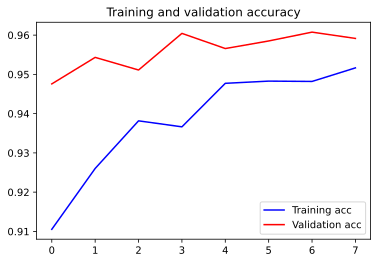

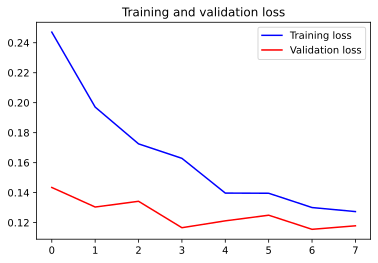

In [ ]:
plot_history(history)

## Step 4: add a technique to enlarge the image 

In [ ]:
EPOCHS               = 8
BATCH_SIZE           = 4 # reduce batch 
LR                   = 1e-3
VAL_SPLIT            = 0.1
IMG_SIZE             = 512 #enlarging the image

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   zoom_range=[0.75, 1.25],
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1 / 255, validation_split=VAL_SPLIT)

train_generator = train_datagen.flow_from_directory(
                    PATH+'train/',
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical',
                    shuffle=True, seed=RANDOM_SEED,
                    subset='training')

test_generator = test_datagen.flow_from_directory(
                    PATH+'train/',
                    target_size=(IMG_SIZE, IMG_SIZE),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical',
                    shuffle=True, seed=RANDOM_SEED,
                    subset='validation')  # set as validation data

Found 15561 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.


In [ ]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, 
                                input_shape=input_shape)
base_model.trainable = True

2022-12-10 02:49:26.929928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 02:49:27.110701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 02:49:27.111698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 02:49:27.113671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258449408/258434480 [==============================] - 8s 0us/step


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
model.load_weights('best_model.hdf5')

NameError: name 'model' is not defined

In [ ]:
checkpoint = ModelCheckpoint('best_model_eff6.hdf5' , monitor = 'val_accuracy',
                             verbose = 1  , mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# Fitting
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
        )

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

# Prediction on test data

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1).argmax(axis=-1)
submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)
print('Save submit')

In [ ]:
submission.head()

# TTA

I'll try to improve the metric with Test Time Augmentation 

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
IMG_SIZE = 224
AUGMENTATIONS = albumentations.Compose([
        
        albumentations.RandomCrop(width=200, height=224),
    
        albumentations.HorizontalFlip(p=0.5),        
        albumentations.VerticalFlip(p=0.5),                  
        albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.01,
                       interpolation=1, border_mode=4, rotate_limit=40, p=0.75),
        albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.5, contrast_limit=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=1, contrast_limit=1)
        ], p=0.5),
        albumentations.GaussianBlur(p=0.05),
        albumentations.HueSaturationValue(p=0.5),
        albumentations.RGBShift(p=0.5),
        albumentations.Resize(IMG_SIZE, IMG_SIZE),
    ])
(train_generator,test_generator,test_sub_generator) = building_generators()

In [ ]:
# add augmentation to sub_generator
test_datagen = ImageDataAugmentor(
        rescale=1/255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT)

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
tta_steps = 10
predictions = []
test_sub_generator.reset()
for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)
test_sub_generator.reset()

pred = np.mean(predictions, axis=0)
predictions = np.argmax(pred, axis=-1) #multiple categories

In [ ]:
submission_tta = pd.DataFrame({'Id': test_sub_generator.filenames,
                            'Category': predictions}, columns=['Id', 'Category'])

submission_tta.to_csv('submission_tta.csv', index=False)

scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.04%


In [ ]:
submission_tta.head()

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

Initially, I tested weaker models, but decided to try a newer model with better results - EfficientNetB7.
After a series of experiments, I concluded that training the entire model does not lead to very good results. So I tried to apply Fine-tuning by dividing the training into 3 steps. In the first part, the upper layers were trained, in the second - half and in the third - all layers were unfrozen.

For a long time I tried to select both augmentation, which was important to us because of the small amount of data, so that it would not be too strong, and made experiments with different layers (BatchNormalization() and a fully connected Dense() layer).
I have chosen Albumentations. The big advantage of this library is that it is faster (according to articles from the Internet) and highly customizable.

As a result, I decided to leave the fully connected layer in the "head", but without BatchNormalization(). On the first two steps it was good, but on the third he was not the best. The results of my experiments can be seen in the table shown (the second step with BatchNormalization is missing, but without Dense(256), because I forgot to enter the data, but the result of the third step is there)

Added the EarlyStopping function to the Keras callback.
I also tried to use ExponentialDecay, but perhaps due to a lack of knowledge and work practice, most likely I made the wrong setting and the results were not as good as with manual adjustment of the learning rate.

I also tried to enlarge the image size to 512 with the usual augmentation proposed by the baseline, based on the previously trained EfficientNetB7 model.

I would also like to try to do Ensembling and try to correctly apply ExponentialDecay to automatically adjust the learning rate.

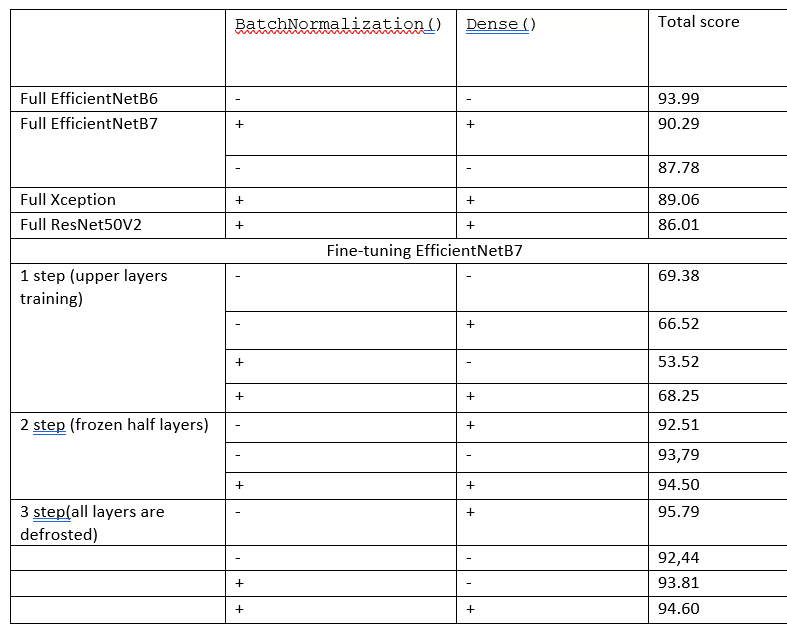